In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emnist/emnist-letters-mapping.txt
/kaggle/input/emnist/emnist-letters-test.csv
/kaggle/input/emnist/emnist-mnist-mapping.txt
/kaggle/input/emnist/emnist-digits-train.csv
/kaggle/input/emnist/emnist-bymerge-mapping.txt
/kaggle/input/emnist/emnist-balanced-train.csv
/kaggle/input/emnist/emnist-digits-test.csv
/kaggle/input/emnist/emnist-balanced-test.csv
/kaggle/input/emnist/emnist-mnist-test.csv
/kaggle/input/emnist/emnist-letters-train.csv
/kaggle/input/emnist/emnist-byclass-train.csv
/kaggle/input/emnist/emnist-bymerge-test.csv
/kaggle/input/emnist/emnist-balanced-mapping.txt
/kaggle/input/emnist/emnist-mnist-train.csv
/kaggle/input/emnist/emnist-digits-mapping.txt
/kaggle/input/emnist/emnist-bymerge-train.csv
/kaggle/input/emnist/emnist-byclass-test.csv
/kaggle/input/emnist/emnist-byclass-mapping.txt
/kaggle/input/emnist/emnist_source_files/emnist-digits-test-labels-idx1-ubyte
/kaggle/input/emnist/emnist_source_files/emnist-bymerge-train-labels-idx1-ubyte
/kaggle/input/

In [2]:
#Importing all relevant libraries

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers
from keras.layers import *
from keras.utils import np_utils

from tqdm import tqdm
import nltk

### About the dataset
The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset. 

* Each row is a separate image
* 785 columns
* First column = class_label (the target variable)
* Each column after represents one pixel value (784 total for a 28 x 28 image)

In [3]:
#Reading using pandas
train_df = pd.read_csv('/kaggle/input/emnist/emnist-balanced-train.csv', header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print(train_df.shape)

(112800, 785)


In [5]:
train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,112800.00000,112800.0,112800.0,112800.0,112800.0,112800.000000,112800.000000,112800.000000,112800.000000,112800.000000,...,112800.000000,112800.0,112800.0,112800.000000,112800.000000,112800.0,112800.0,112800.0,112800.0,112800.0
mean,23.00000,0.0,0.0,0.0,0.0,0.001365,0.011560,0.020700,0.017438,0.018475,...,0.000310,0.0,0.0,0.002163,0.000284,0.0,0.0,0.0,0.0,0.0
std,13.56472,0.0,0.0,0.0,0.0,0.235046,1.221826,1.658797,1.602478,1.719549,...,0.104211,0.0,0.0,0.726499,0.095279,0.0,0.0,0.0,0.0,0.0
min,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,11.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,23.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,35.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,46.00000,0.0,0.0,0.0,0.0,63.000000,192.000000,217.000000,217.000000,217.000000,...,35.000000,0.0,0.0,244.000000,32.000000,0.0,0.0,0.0,0.0,0.0


In [6]:
train_df.shape

(112800, 785)

We have 112800 rows (images), each described using 784 variables 28X28 pixels plus one column as output variable (the first column)



### Creating label dictionary

The output variables' values comprise of 0 to 46 values where 0-9 stands for 0-9 numbers, 10-35 stands for uppercase A-Z and 35+ stand for lowercase alphabets. We will thus create a dictionary which will have these as key and value pairs.

In our dataset, there is a file emnist-balanced-mapping which contains the characters and their ASCII equivalents. We can have the index column as the key of the dictionary and the value ASCII code converted to char as the value of the dictionary.

In [7]:
#Reading the file
label_map = pd.read_csv("/kaggle/input/emnist/emnist-balanced-mapping.txt", 
                        delimiter = ' ', 
                        index_col=0, 
                        header=None, 
                        squeeze=True)
label_map.head()

0
0    48
1    49
2    50
3    51
4    52
Name: 1, dtype: int64

In [8]:
#Initialising an empty dictionary
label_dictionary = {}

#Running a loop for ASCII equivalent to character conversion
for index, label in enumerate(label_map):
    label_dictionary[index] = chr(label)

label_dictionary

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

My area of interst is only the Hand Writing Recognition of Numbers and Block letters. Thus dropping the lowercase characters from the dataset.

In [9]:
#train_df[~train_df[0].isin(np.arange(36, 47))]
train_df_new = train_df[train_df[0].isin(np.arange(0, 36))]

train_df_new

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112795,22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112796,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112797,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112798,31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
#Checking
train_df_new[0].describe()

count    86400.000000
mean        17.500000
std         10.388355
min          0.000000
25%          8.750000
50%         17.500000
75%         26.250000
max         35.000000
Name: 0, dtype: float64

min value is 0 and max value is 35. Thus, only numbers and uppercase characters are there in the new dataframe.

We will next split this output variable (y) from the input variables (x)

In [11]:
# Resetting Index
train_df_new.reset_index(inplace=True)
train_df_new

,index,0,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,3,15,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,26,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,32,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,20,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,112795,22,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86396,112796,17,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86397,112797,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86398,112798,31,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
x_train = train_df_new.loc[:, 1:]
y_train = train_df_new.loc[:, 0]

x_train.shape, y_train.shape

((86400, 784), (86400,))

### Visualising Sample data

In [13]:
# Sample entry number 1000
sample_image = x_train.iloc[1000]
sample_label = y_train.iloc[1000]
sample_image.shape, sample_label

((784,), 19)

Label entry No. 1000: J


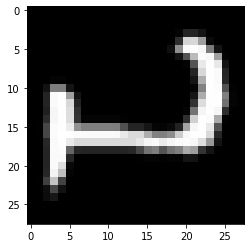

In [14]:
#Init Height and Weight
W = 28
H = 28

print("Label entry No. 1000:", label_dictionary[sample_label])
plt.imshow(sample_image.values.reshape(W, H), cmap=plt.cm.gray)
plt.show()

It is quite visible that the image is rotated anticlockwise 90 degrees and flipped as well. We will thus define a function to rotate and flip and see if it works on the sample image.

Label entry 1000: J


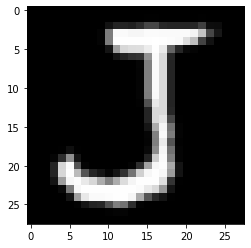

In [15]:
def flip_and_rotate(image):
    W = 28
    H = 28
    image = image.reshape(W, H)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

print("Label entry 1000:", label_dictionary[sample_label])
plt.imshow(flip_and_rotate(sample_image.values), cmap=plt.cm.gray)
plt.show()

Next we want to apply reshape_and_rotate to all images in X_train

In [16]:
x_train = np.apply_along_axis(flip_and_rotate, 1, x_train.values)
x_train.shape

(86400, 28, 28)

### Visualising More Samples

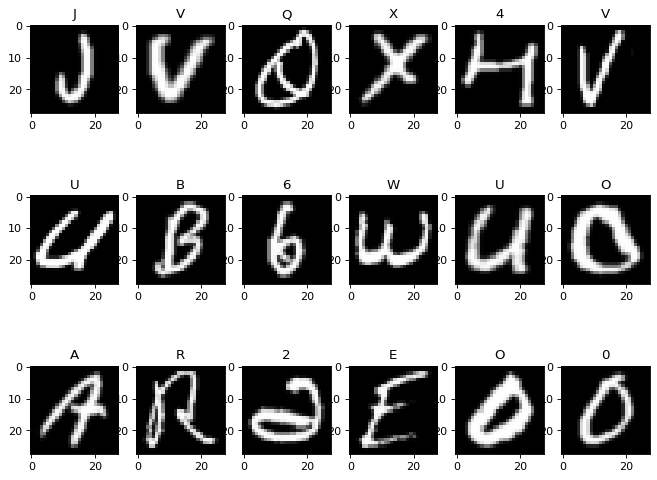

In [17]:
plt.figure(figsize=(10, 8), dpi=80)
for i in range(100, 118):
    plt.subplot(3,6,i-99)
    plt.imshow(x_train[i], cmap=plt.cm.gray)
    plt.title(label_dictionary[y_train[i]])

### Normalizing the Data

In [18]:
#Data Scaling to bring the input values between 0 to 1
x_train = x_train.astype('float32') / 255
x_train[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00784314, 0.03529412, 0.1254902 ,
        0.01176471, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.1333

### One Hot Encoding of the Output Labels

As the output values are integers, from 0 to 35, we must perform one hot encoding so as to get a number of output columns comprised of 0 and 1 class labels.

In [19]:
#Finding the number of output columns
number_of_classes = y_train.nunique()
number_of_classes

36

In [20]:
#One hot encoding of numpy array
y_train = np_utils.to_categorical(y_train, number_of_classes)
y_train.shape

(86400, 36)

### Reshaping the train data

As tensorflow requires 4D Array, (batch X width X height X channel) and our x_train is 3D array (no. of images X width X height), we will be adding one more dimension to the x_train

In [21]:
x_train.shape

(86400, 28, 28)

In [22]:
x_train = x_train.reshape(-1, W, H, 1)
x_train.shape

(86400, 28, 28, 1)

### Train and Validation Split

We will be dividing the input dataset into train and validation in the ratio of 90:10 for Model Building

In [ ]:
# Split 10% validation 
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  test_size= 0.1, 
                                                  random_state=88)

### Model Building

In [ ]:
'''model = Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(W, H, 1)))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(84, activation='relu'))
model.add(layers.Dense(number_of_classes, activation='softmax'))

model.summary()'''

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Dropout

W, H = 28, 28  # Set image dimensions
number_of_classes = 36 # Adjust to match EMNIST set (balanced = 47, byclass = 62, etc.)

model = Sequential()

# Conv Block 1
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(W, H, 1)))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

# Conv Block 2
model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

# Fully Connected Layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.5))  # helps generalization
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(number_of_classes, activation='softmax'))

model.summary()


In [ ]:
# Optimizing Algorithm for Backpropagation

optimizer_name = 'adam'

model.compile(loss='categorical_crossentropy', optimizer=optimizer_name, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
mcp_save = ModelCheckpoint('my_model.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='auto')

In [ ]:
#Model Fitting
'''
history = model.fit(x_train,
                    y_train, 
                    epochs=2, 
                    batch_size=32, 
                    verbose=1, 
                    validation_split=0.1,
                    callbacks=[early_stopping, mcp_save])
                    '''
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_loss',      # You can also use 'val_accuracy'
    patience=3,              # Stop after 3 epochs with no improvement
    restore_best_weights=True
)

mcp_save = ModelCheckpoint(
    'best_model.h5',         # Save the best model to this file
    save_best_only=True,
    monitor='val_loss',      # Monitor validation loss
    mode='min'               # Save when val_loss decreases
)
history = model.fit(
    x_train,
    y_train,
    epochs=20,               # Use more than 2 epochs for better performance
    batch_size=32,
    verbose=1,
    validation_split=0.1,
    callbacks=[early_stopping, mcp_save]
)


### Plotting Accuracy and Loss

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc*100:.2f}%")


In [30]:
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

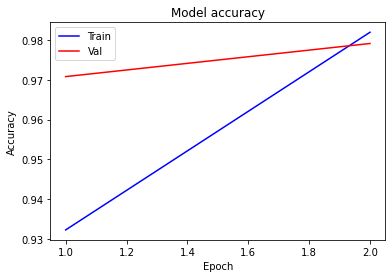

In [31]:
# Accuracy curve
plotgraph(epochs, acc, val_acc)

Loss Curve


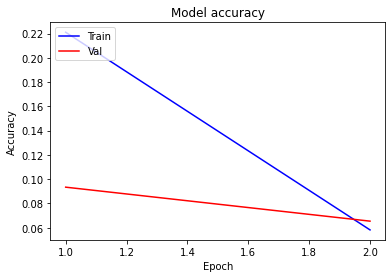

In [32]:
# loss curve
print('Loss Curve')
plotgraph(epochs, loss, val_loss)


In [33]:
# Load best model
model = load_model('/kaggle/working/my_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 48)        38448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 48)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1200)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               307456    
_________________________________________________________________
dense_1 (Dense)              (None, 84)                2

### Prediction on the Validation Data

In [34]:
# Storing all the predicted values in y_pred variable
y_pred = model.predict(x_val)
# Finding shape
y_pred.shape

(2400, 10)

### Visualizing some predicted values

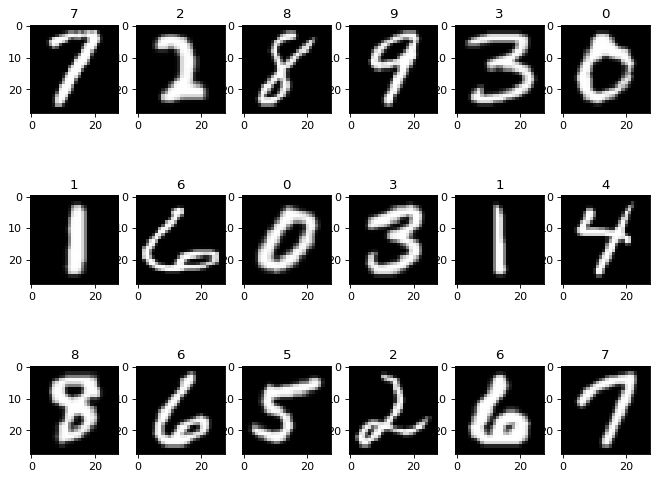

In [35]:
plt.figure(figsize=(10, 8), dpi=80)
for i in range(200, 218):
    plt.subplot(3,6,i-199)
    plt.imshow(x_val[i], cmap=plt.cm.gray)
    plt.title(label_dictionary[y_pred[i].argmax()])

### Validation Accuracy

In [36]:
val_acc = model.evaluate(x_val, y_val)
print('Loss value is ',val_acc[0])
print('Accuracy value is ',val_acc[1])

75/75 [==============================] - 1s 7ms/step - loss: 0.0447 - accuracy: 0.9871
Loss value is  0.04468531906604767
Accuracy value is  0.9870833158493042


### Predicting the test data that came along with the dataset

In [37]:
#Loading the dataset
test_df = pd.read_csv('/kaggle/input/emnist/emnist-balanced-test.csv', header=None)
test_df.shape

(18800, 785)

In [38]:
#Removing lowercase entries
test_df_new = test_df[test_df[0].isin(np.arange(0, 10))]
test_df_new.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,4000.00000,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,...,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0
mean,4.50000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,2.87264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,4.50000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,7.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,9.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
#Splitting into x and y
x_test = test_df_new.loc[:, 1:]
y_test = test_df_new.loc[:, 0]

x_test.shape, y_test.shape

((4000, 784), (4000,))

In [40]:
#Flipinng and rotating
x_test = np.apply_along_axis(flip_and_rotate, 1, x_test.values)
y_test = np_utils.to_categorical(y_test, number_of_classes)

x_test.shape, y_test.shape

((4000, 28, 28), (4000, 10))

In [41]:
#Normalisation
x_test = x_test.astype('float32') / 255

In [42]:
#Reshaping (Changing Dimension)
x_test = x_test.reshape(-1, W, H, 1)
x_test.shape

(4000, 28, 28, 1)

In [43]:
#Evaluating Model
test_acc = model.evaluate(x_test, y_test)
print('Loss value is ',test_acc[0])
print('Accuracy value is ',test_acc[1])

125/125 [==============================] - 1s 7ms/step - loss: 0.0481 - accuracy: 0.9852
Loss value is  0.048063263297080994
Accuracy value is  0.9852499961853027


In [44]:
#Prediction
y_pred_test = model.predict(x_test)
# Finding shape
y_pred_test.shape

(4000, 10)

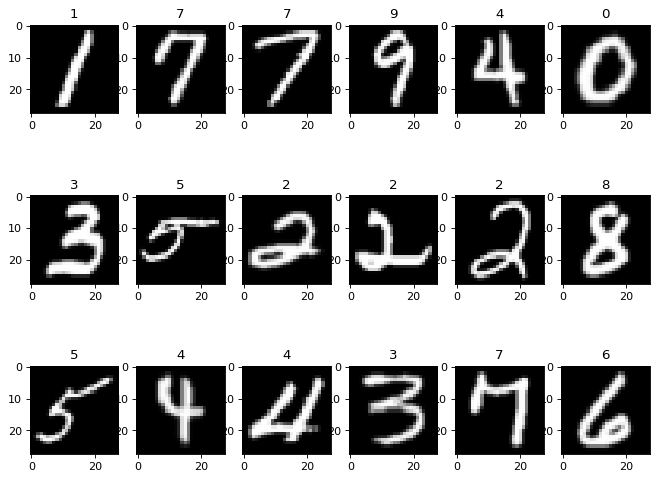

In [45]:
# Visualising some predicted values

plt.figure(figsize=(10, 8), dpi=80)
for i in range(200, 218):
    plt.subplot(3,6,i-199)
    plt.imshow(x_test[i], cmap=plt.cm.gray)
    plt.title(label_dictionary[y_pred_test[i].argmax()])

# **Testing on new image**

In [46]:
import cv2
import numpy as np

# read image file
#img = cv2.imread('/kaggle/input/testing-data-emnist/P.png')
img = cv2.imread('/kaggle/input/testing-data-emnist2/8.png')
# convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = 255 - gray
# resize image to 28x28 pixels
gray_resized = cv2.resize(gray, (28, 28))

# reshape image to ( , 28, 28, 1)
gray_reshaped = gray_resized.reshape(1, 28, 28, 1)

# display shape of reshaped image
print(gray_reshaped.shape)  # should output (1, 28, 28, 1)

(1, 28, 28, 1)


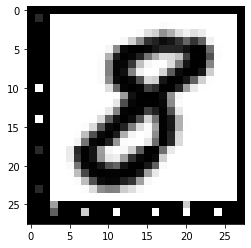

In [47]:
plt.imshow(gray_reshaped[0], cmap=plt.cm.gray)

In [48]:
#Prediction
y_pred_test1 = model.predict(gray_reshaped)
# Finding shape
y_pred_test1.shape

(1, 10)

In [49]:
label_dictionary[y_pred_test1.argmax()]

'8'

Text(0.5, 1.0, '8')

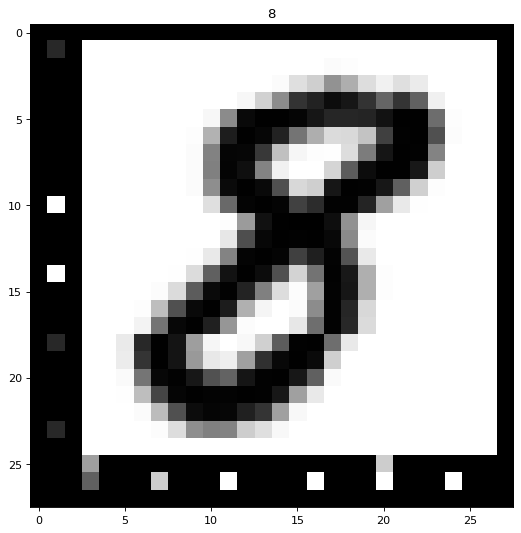

In [50]:
plt.figure(figsize=(10, 8), dpi=80)
plt.imshow(gray_reshaped[0], cmap=plt.cm.gray)
plt.title(label_dictionary[y_pred_test1[0].argmax()])

In [51]:
model.save('/kaggle/working/my_model.h5')
